In [10]:
import sqlite3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
db_name = "result.db"


def fetch_data(query: str):
    with sqlite3.connect(db_name) as connection:
        return connection.execute(query).fetchall()


def fetch_df(query: str, **kwargs) -> pd.DataFrame:
    with sqlite3.connect(db_name) as connection:
        return pd.read_sql(query, connection, **kwargs)

<AxesSubplot:ylabel='Count'>

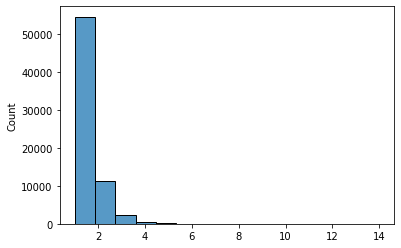

In [4]:
replies_count = np.array(fetch_data(
    "SELECT replies_count FROM message_replies"
)).reshape(-1)
sns.histplot(replies_count, bins=replies_count.max()+1)

In [28]:
n_posts = len(replies_count)

for threshold in [1, 2, 3, 4]:
    n_replies = np.sum(replies_count >= threshold)
    print(f"# replies >= {threshold}: {n_replies / n_posts:.3f} ({n_replies})")

# replies >= 1: 1.000 (68975)
# replies >= 2: 0.209 (14401)
# replies >= 3: 0.046 (3174)
# replies >= 4: 0.013 (878)


<AxesSubplot:xlabel='replies_count', ylabel='max_biased_value'>

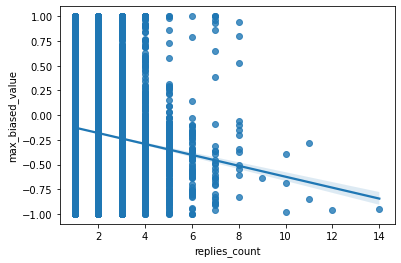

In [13]:
replies_to_emotion = fetch_df(
    """
    WITH message_to_aggregate AS (
        SELECT
            replies_count,
            AVG(value) as avg_value,
            MIN(value) as min_value,
            MAX(value) as max_value
        FROM message_replies
        INNER JOIN answer ON message_replies.message_id = answer.reply_to_msg_id AND answer.text != ""
        INNER JOIN sentiment ON answer.message_id = sentiment.message_id
        GROUP BY message_replies.message_id, message_replies.replies_count
    )

    SELECT
        replies_count,
        CASE
            WHEN avg_value < 0 THEN min_value
            ELSE max_value
        END max_biased_value
    FROM message_to_aggregate
    """
)
sns.regplot(data=replies_to_emotion, x="replies_count", y="max_biased_value")

<AxesSubplot:xlabel='post_sentiment', ylabel='avg_answer_sentiment'>

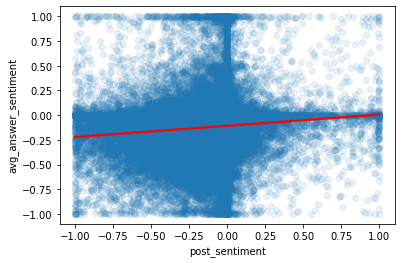

In [16]:
emotion_to_reply_emotions = fetch_df(
    """
    SELECT
        post_s.value as post_sentiment,
        AVG(ans_s.value) as avg_answer_sentiment
    FROM message_replies
    INNER JOIN answer ON
        message_replies.message_id = answer.reply_to_msg_id AND
        answer.text != ""
    INNER JOIN sentiment post_s ON
        message_replies.message_id = post_s.message_id
    INNER JOIN sentiment ans_s ON
        answer.message_id = ans_s.message_id
    GROUP BY message_replies.message_id, post_s.value
    HAVING COUNT(ans_s.value) > 0
    """
)

sns.regplot(
    data=emotion_to_reply_emotions,
    x="post_sentiment",
    y="avg_answer_sentiment",
    scatter_kws={"alpha": 0.1},
    line_kws={"color": "red"}
)

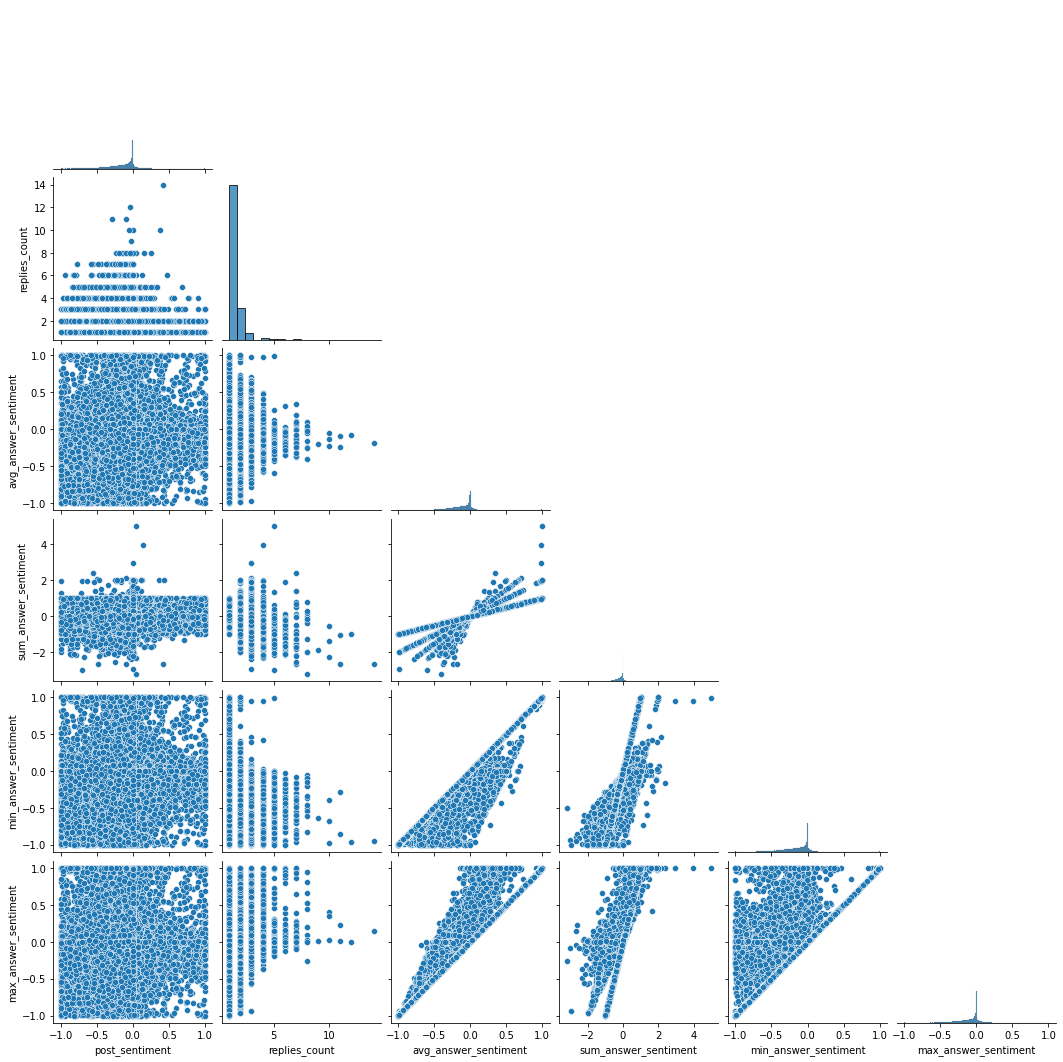

In [25]:
post_answer_params = fetch_df(
    """
    SELECT
        post_s.value as post_sentiment,
        message_replies.replies_count as replies_count,
        COALESCE(AVG(ans_s.value), 0) as avg_answer_sentiment,
        COALESCE(SUM(ans_s.value), 0) as sum_answer_sentiment,
        COALESCE(MIN(ans_s.value), 0) as min_answer_sentiment,
        COALESCE(MAX(ans_s.value), 0) as max_answer_sentiment
    FROM message_replies
    INNER JOIN answer ON
        message_replies.message_id = answer.reply_to_msg_id AND
        answer.text != ""
    INNER JOIN sentiment post_s ON
        message_replies.message_id = post_s.message_id
    INNER JOIN sentiment ans_s ON
        answer.message_id = ans_s.message_id
    GROUP BY message_replies.message_id, post_s.value
    """
)
sns.pairplot(post_answer_params, corner=True)